# Model uncertainty with Monte Carlo dropout in TensorFlow

Deep learning models have shown amazing performance in a lot of fields such as autonomous driving, manufacturing, and medicine, to name a few. However, these are fields in which representing model uncertainty is of crucial importance. The standard deep learning tools for regression and classification do not capture model uncertainty. In classification, predictive probabilities obtained at the end of the pipeline (the softmax output) are often erroneously interpreted as model confidence. Gal et. al argue, that a model can be uncertain in its predictions even with a high softmax output. Passing a point estimate of a function through a softmax results in extrapolations with unjustified high confidence for points far from the training data.

Model uncertainty is indispensable for the deep learning practitioner as well. With model confidence at hand we can treat uncertain inputs and special cases explicitly. I recommend Vincents talk from pydata london for a general view on the topic. For example, in the case of classification, a model might return a result with high uncertainty. In this case we might decide to pass the input to a human for classification.

Gal et. al show that the use of dropout in neural networks can be interpreted as a Bayesian approximation of a Gaussian process, a well known probabilistic model. Dropout is used in many models in deep learning as a way to avoid over-fitting, and they show that dropout approximately integrates over the models’ weights. In this article we will see how to represent model uncertainty of existing dropout neural networks. This approach, called Monte Carlo dropout, will mitigates the problem of representing model uncertainty in deep learning without sacrificing either computational complexity or test accuracy and can be used for all kind of models trained with dropout.

**References:**

* https://www.depends-on-the-definition.com/model-uncertainty-in-deep-learning-with-monte-carlo-dropout/
* https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571

![Compute Uncertainty Theory](images_notebooks/nn_compute_uncertainty.png)

![Dropout Enabled neurons](images_notebooks/nn_dropout_enable.png)

## Import libraries

In [1]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import tqdm

## Predefine some basic variables

In [2]:
n_epochs = 50
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

## Load data

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return size, power_labels[n]+'bytes'

In [7]:
print("size of X train:", format_bytes(x_train.nbytes))
print("size of X test:", format_bytes(x_test.nbytes))

size of X train: (179.443359375, 'megabytes')
size of X test: (29.9072265625, 'megabytes')


In [8]:
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Build CNN

Build a simple convolutional network with and without Monte Carlo dropout and compare their properties

In [9]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

In [10]:
def get_model(mc=False, act="relu"):
    inp = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.5, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

### Simple model initiation

In [11]:
model = get_model(mc=False, act="relu")

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               117977

### Monte Carlo model initation

In [13]:
mc_model = get_model(mc=True, act="relu")

In [14]:
mc_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179

## Train the simple CNN model

In [15]:
h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/50
469/469 [==============================] - 11s 22ms/step - loss: 2.2967 - accuracy: 0.1156 - val_loss: 2.2241 - val_accuracy: 0.2157
Epoch 2/50
469/469 [==============================] - 10s 21ms/step - loss: 2.2183 - accuracy: 0.2281 - val_loss: 2.1254 - val_accuracy: 0.5553
Epoch 3/50
469/469 [==============================] - 10s 21ms/step - loss: 2.1239 - accuracy: 0.3673 - val_loss: 2.0021 - val_accuracy: 0.6611
Epoch 4/50
469/469 [==============================] - 10s 21ms/step - loss: 2.0046 - accuracy: 0.4703 - val_loss: 1.8426 - val_accuracy: 0.7128
Epoch 5/50
469/469 [==============================] - 10s 21ms/step - loss: 1.8575 - accuracy: 0.5344 - val_loss: 1.6517 - val_accuracy: 0.7450
Epoch 6/50
469/469 [==============================] - 10s 21ms/step - loss: 1.6931 - accuracy: 0.5757 - val_loss: 1.4474 - val_accuracy: 0.7755
Epoch 7/50
469/469 [==============================] - 10s 21ms/step - loss: 1.5220 - accuracy: 0.6129 - val_loss: 1.2506 - val_accuracy:

## Evaluate the simple CNN model

In [16]:
# score of the normal model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2905712127685547
Test accuracy: 0.9172999858856201


## Train the MC CNN model

In [17]:
h_mc = mc_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/50
469/469 [==============================] - 10s 22ms/step - loss: 2.2915 - accuracy: 0.1341 - val_loss: 2.2618 - val_accuracy: 0.2275
Epoch 2/50
469/469 [==============================] - 10s 22ms/step - loss: 2.2513 - accuracy: 0.2578 - val_loss: 2.2129 - val_accuracy: 0.3437
Epoch 3/50
469/469 [==============================] - 10s 22ms/step - loss: 2.1993 - accuracy: 0.3651 - val_loss: 2.1468 - val_accuracy: 0.4375
Epoch 4/50
469/469 [==============================] - 10s 22ms/step - loss: 2.1275 - accuracy: 0.4473 - val_loss: 2.0538 - val_accuracy: 0.4986
Epoch 5/50
469/469 [==============================] - 10s 22ms/step - loss: 2.0308 - accuracy: 0.5043 - val_loss: 1.9299 - val_accuracy: 0.5501
Epoch 6/50
469/469 [==============================] - 10s 22ms/step - loss: 1.8982 - accuracy: 0.5537 - val_loss: 1.7693 - val_accuracy: 0.5835
Epoch 7/50
469/469 [==============================] - 10s 21ms/step - loss: 1.7358 - accuracy: 0.5853 - val_loss: 1.5885 - val_accuracy:

## Make predictions with the MC CNN model (500 per instance)

In [18]:
mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 500/500 [03:41<00:00,  2.26it/s]


In [19]:
len(mc_predictions)

500

In [20]:
mc_predictions[0].shape

(10000, 10)

## Evaluate the MC CNN model

In [21]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))

MC accuracy: 87.3%


In [22]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)

In [23]:
mc_ensemble_pred.shape

(10000,)

In [24]:
mc_ensemble_pred[0]

7

In [25]:
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)

In [26]:
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

MC-ensemble accuracy: 91.7%


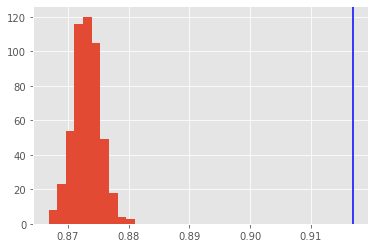

In [27]:
plt.hist(accs);
plt.axvline(x=ensemble_acc, color="b");

## Explore the Monte Carlo predictions

Predictions with probability and uncertainty

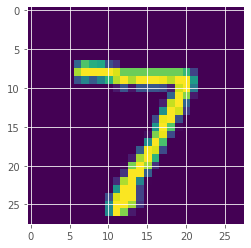

In [28]:
idx = 0
plt.imshow(x_test[idx][:,:,0])

In [29]:
p0 = np.array([p[idx] for p in mc_predictions])
print("p0 shape: {}".format(p0.shape))
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))

p0 shape: (500, 10)
posterior mean: 7
true label: 7


In [30]:
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

class: 0; proba: 0.1%; var: 0.38% 
class: 1; proba: 0.0%; var: 0.07% 
class: 2; proba: 0.0%; var: 0.19% 
class: 3; proba: 0.3%; var: 0.90% 
class: 4; proba: 0.0%; var: 0.14% 
class: 5; proba: 0.0%; var: 0.10% 
class: 6; proba: 0.0%; var: 0.13% 
class: 7; proba: 98.0%; var: 3.79% 
class: 8; proba: 0.1%; var: 0.45% 
class: 9; proba: 1.4%; var: 2.89% 


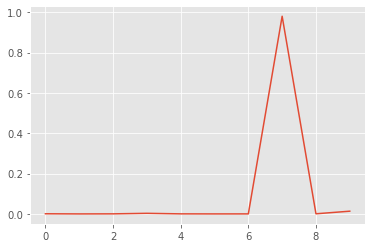

In [31]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);

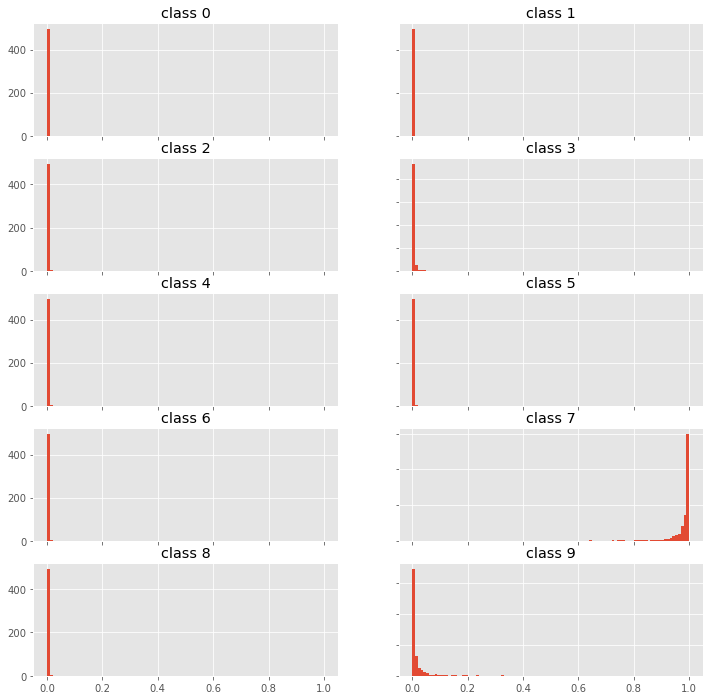

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1));
    ax.set_title(f"class {i}")
    ax.label_outer()

The model is correct but fairly uncertain. This seems to be a hard example.

## Selection by probability

select images by the predictive mean, our probability.

In [33]:
max_means = []
preds = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [34]:
best_mean_probabilities = (np.array(max_means)).argsort()[:10]
best_mean_probabilities

array([149, 195, 483, 443, 406,   8,  33, 175, 119, 193])

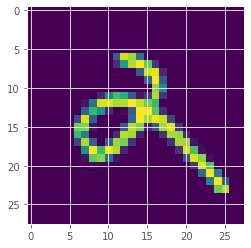

In [35]:
plt.imshow(x_test[best_mean_probabilities[0]][:,:,0])

It seems the image from above was the one the model was most uncertain about by probability

## Selection by variance

select the images by the variance of the predictions

In [36]:
max_vars = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    max_vars.append(px.std(axis=0)[px.mean(axis=0).argmax()])

In [37]:
max_vars[:3]

[0.037947796, 0.20494477, 0.06536839]

In [38]:
negativesss = -np.array(max_vars)

In [39]:
negativesss.shape

(500,)

In [40]:
negativesss[:3]

array([-0.0379478 , -0.20494477, -0.06536839], dtype=float32)

In [41]:
-np.array(max_vars)

array([-0.0379478 , -0.20494477, -0.06536839, -0.04772786, -0.1197573 ,
       -0.06717464, -0.14074336, -0.17430907, -0.2527202 , -0.23491494,
       -0.0791084 , -0.19421315, -0.1530418 , -0.06304537, -0.0530577 ,
       -0.16653442, -0.15583153, -0.06012925, -0.21314432, -0.08204075,
       -0.22137086, -0.121338  , -0.19997822, -0.08311925, -0.12976043,
       -0.06753445, -0.11671486, -0.10055397, -0.08192123, -0.12872188,
       -0.0636328 , -0.1571135 , -0.16574931, -0.22523005, -0.1188217 ,
       -0.06908001, -0.05149782, -0.06407053, -0.24499571, -0.05798316,
       -0.10782165, -0.0883157 , -0.15231939, -0.14939983, -0.15106317,
       -0.2010947 , -0.22906291, -0.11201318, -0.14186881, -0.0934125 ,
       -0.06387635, -0.11761438, -0.12078109, -0.15996702, -0.19832121,
       -0.21845813, -0.03142769, -0.08247396, -0.14872088, -0.16560045,
       -0.12534256, -0.20509174, -0.16852634, -0.23542306, -0.10309567,
       -0.18762964, -0.19154067, -0.05928563, -0.0803299 , -0.09

In [42]:
lowest_variances = (-np.array(max_vars)).argsort()[:10]
lowest_variances

array([412, 449, 172, 405, 124, 126, 380, 305, 280,   8])

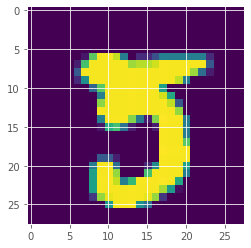

In [43]:
plt.imshow(x_test[lowest_variances[0]][:,:,0])

## Uncertainty measure behavior

How well can the uncertainty estimate identify out-of-scope samples?

### Create random images and see what the model predicts

In [44]:
random_img = np.random.random(input_shape)

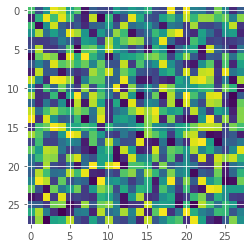

In [45]:
plt.imshow(random_img[:,:,0]);

In [46]:
random_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(np.array([random_img]))
    random_predictions.append(y_p)

100%|██████████| 500/500 [00:09<00:00, 52.46it/s]


In [47]:
p0 = np.array([p[0] for p in random_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 3

class: 0; proba: 3.8%; var: 6.05% 
class: 1; proba: 0.5%; var: 0.94% 
class: 2; proba: 34.6%; var: 24.24% 
class: 3; proba: 44.9%; var: 26.11% 
class: 4; proba: 1.0%; var: 2.01% 
class: 5; proba: 8.2%; var: 11.29% 
class: 6; proba: 2.2%; var: 4.59% 
class: 7; proba: 1.0%; var: 1.90% 
class: 8; proba: 3.5%; var: 5.57% 
class: 9; proba: 0.3%; var: 1.04% 


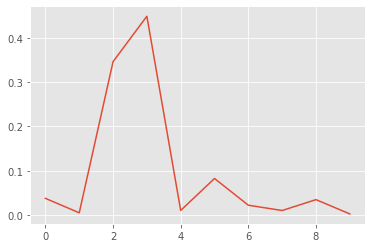

In [48]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);

it is clearly just random noise. If you try different random images, you will find that the model always predicts them as eight. So there might be something wrong with the “understanding” of eight in our model. This is good to know and keep in mind when using the model.

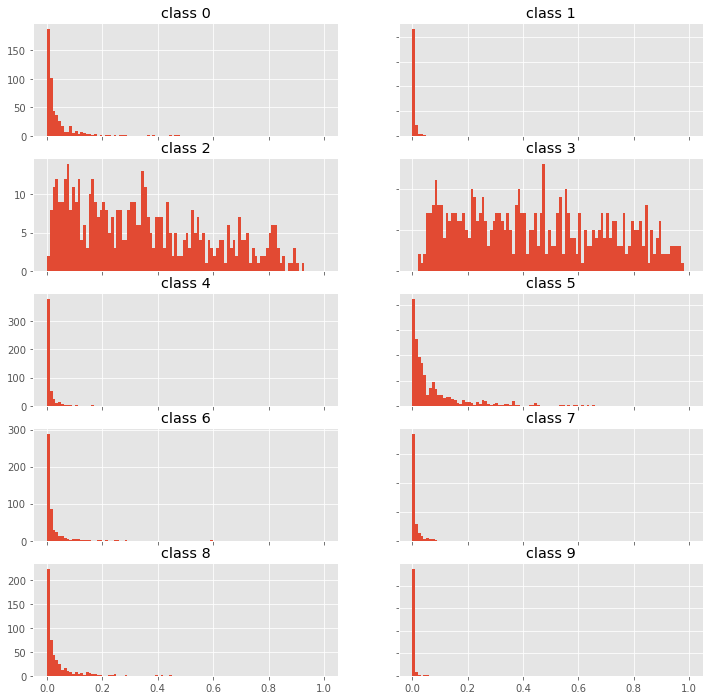

In [49]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1));
    ax.set_title(f"class {i}")
    ax.label_outer()

## `np.argsort()`

In [50]:
in_arr = np.array([ 2, 0, 1, 5, 4, 1, 9])

In [51]:
in_arr.shape

(7,)

In [52]:
out_arr = in_arr.argsort()

In [53]:
print ("Output sorted array indices : ", out_arr)

Output sorted array indices :  [1 2 5 0 4 3 6]


In [54]:
print("Output sorted array : ", in_arr[out_arr])

Output sorted array :  [0 1 1 2 4 5 9]


In [55]:
neg_arr = -in_arr

In [56]:
neg_arr

array([-2,  0, -1, -5, -4, -1, -9])

In [57]:
neg_arr.argsort()

array([6, 3, 4, 0, 2, 5, 1])

In [58]:
lista = [1, 3, 2, 5, 7, 6]

In [59]:
-np.array(lista).argsort()

array([ 0, -2, -1, -3, -5, -4])

In [60]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [61]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=50)
model.evaluate(X_test, y_test)

Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 10.7436 - accuracy: 0.7013
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5531 - accuracy: 0.8487
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4140 - accuracy: 0.8839
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3635 - accuracy: 0.9002
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3418 - accuracy: 0.9091
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3270 - accuracy: 0.9145
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3105 - accuracy: 0.9165
Epoch 8/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2932 - accuracy: 0.9233
Epoch 9/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2984 - accuracy: 0.9233
Epoch 10/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.28

[0.19708745181560516, 0.9657999873161316]

In [62]:
def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)
     
def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1)

In [63]:
y_pred = predict_class(X_test, model, 100)
acc = np.mean(y_pred == y_test)

In [64]:
y_pred_proba = predict_proba(X_test, model, 100)

In [65]:
softmax_output = np.round(model.predict(X_test[1:2]), 3)
mc_pred_proba = np.round(y_pred_proba[1], 3)

In [66]:
print("softmax_output:", softmax_output)
print("mc_pred_proba:", mc_pred_proba)

softmax_output: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
mc_pred_proba: [0.001 0.01  0.98  0.001 0.001 0.001 0.001 0.001 0.002 0.001]
